### Intro

В разработке нашего решения мы опирались на понимание задачи прогнозирования спроса для бизнеса. Посылки состоят в том, что, во-первых, данных о различных товарах не одинаково качественны, а во-вторых, стоимости ошибки прогноза для разных товаров не равны. Можно выделить условные топ-товары, продажи которых составляют основу бизнеса. Делая анализ, мы отметили, что топ-50 товаров по продажам (порядка 2% от общего числа наименований) совокупно формируют 20% выручки. Мы полагаем, что максимально качественный прогноз этой группы критичен и при этом возможен: по самым продаваемым товарам собрано много данных. Тогда как редкие позиции, обеспечивающие малую долю выручки, и их низкокачественный прогноз - это то ограничение нашей системы, которое можно и следует принять.

Таким образом, мы выделяем в общей массе пар товар-магазин две группы: топ-товары и остальные. Для топ-товаров достаточно данных, чтобы для каждой пары построить собственный плотный временной ряд и использовать для прогнозирования лаговые переменные и скользящие средние самой пары. Для более редких товаров, у которых нет стабильных продаж, мы предполагаем отталкиваться от продаж товара по всем магазинам, с одной стороны, и продаж различных товаров в заданном магазине. Также мы планируем рассмотреть продажи подкатегории и категории, к которым принадлежит товар - это может помочь в прогнозировании товаров, у которых совсем нет истории продаж.

На данный момент мы прогнозировали обе группы градиентным бустингом, но считаем это двумя разными моделями, т.к. используем разные подходы к генерации признаков.

В данном ноутбуке мы делаем прогноз для товаров, которые мы назвали топ-150. Это первые 150 пар товар-магазин по суммарным продажам в штуках, плюс товары, которые в этот список не попали, их продажи ниже, но они продавались не менее 80% от всех представленных дней, т.е. имеют достаточно плотные временные ряды.

Ноутбук состоит из следующих частей: предобработка данных, генерация признаков, обучение модели, предсказание. В конце каждой части мы сформулировали промежуточные итоги

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna
from prophet import Prophet
import pickle

c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [4]:
#my function to check intersections and differences between sets of items
def check_sets(df1, col1, df2, col2, name1='first', name2='second'):
    set1 = set(df1[col1].unique())
    set2 = set(df2[col2].unique())
    print('in both files:', len(set1 & set2))
    print(f'in {name1} but not in {name2}:', len(set1 - set2))
    print(f'in {name2} but not in {name1}:', len(set2 - set1))

In [5]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [6]:
sales.shape

(883015, 8)

In [7]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [8]:
#estimate cases where sales in units are zero and in rubles not, or vice versa
zero_nonzero_sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] == 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] != 0))]
zero_nonzero_sales.shape

(66882, 8)

In [9]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [10]:
#estimate negative sales
minus_sales = sales[(sales['pr_sales_in_rub'] < 0) | (sales['pr_sales_in_units'] < 0) | (sales['pr_promo_sales_in_rub'] < 0) |(sales['pr_promo_sales_in_units'] < 0)]
minus_sales.shape

(70, 8)

In [11]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [12]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [13]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.shape

(661192, 5)

In [14]:
#detect top50 item-store pairs
by_pair = oneline.groupby('store_item')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('pr_sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('pr_sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)

pr_sales_in_units        \
                                                                 sum count   
store_item                                                                   
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...           51500.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...           42088.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...           34255.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...           32923.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...           29678.0   352   
...                                                              ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...            5469.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...            5417.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...            5399.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...            5364.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...            5337.0   192   

                                                   pr_sales_in_rub        \
                                                               sum count   
store_item                                                                 
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        879274.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...       1999391.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...       1070819.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...       4187731.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        963222.0   352   
...                                                            ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        324306.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...         84293.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        643395.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        328648.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        913631.0   192   

                                                   all_sales_share  
                                                                    
store_item                                                          
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        0.168569  
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...        0.383311  
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...        0.205291  
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...        0.802847  
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        0.184663  
...                                                            ...  
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        0.062174  
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...        0.016160  
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        0.123348  
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        0.063006  
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        0.175156  

[150 rows x 5 columns]

In [15]:
#get top50 and check if there is data we're going to drop in those lines
top150 = by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150).reset_index()
zero_nonzero_sales['store_item'] = zero_nonzero_sales['st_id'].str.cat(zero_nonzero_sales['pr_sku_id'], sep='-')
check_sets(zero_nonzero_sales, 'store_item', top150.reset_index(), 'store_item', 'problem_data', 'top150')

in both files: 44
in problem_data but not in top150: 2907
in top150 but not in problem_data: 106


In [16]:
by_pair = by_pair.reset_index()

In [17]:
#separate top 150
no_top150 = by_pair[~by_pair['store_item'].isin(top150['store_item'])]
no_top150.shape

(5980, 6)

In [18]:
#find those pairs whose 80+ % of time series are non-zero. join with top 150
most_frequent = no_top150[no_top150[('pr_sales_in_units', 'count')] >= 352*0.8]
flagman = pd.concat([top150, most_frequent])
flagman.shape

(857, 6)

In [19]:
oneline = oneline.reset_index()
oneline.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1,1.0,81.0,1.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1,1.0,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1,1.0,81.0,1.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,0,1.0,146.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,0,1.0,146.0,0.0,0.0


In [21]:
#make train dataset out of top150 and their sales
train = oneline.copy()
train.shape

(661192, 7)

In [22]:
train = train[['store_item', 'date', 'pr_sales_in_units']]
train.head()

,store_item,date,pr_sales_in_units
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,1.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,1.0


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661192 entries, 0 to 661191
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   store_item         661192 non-null  object 
 1   date               661192 non-null  object 
 2   pr_sales_in_units  661192 non-null  float64
dtypes: float64(1), object(2)
memory usage: 15.1+ MB


In [24]:
train['date'] = pd.to_datetime(train['date']).dt.normalize()

In [25]:
train['date'].describe()

count                           661192
mean     2023-01-25 00:23:34.797517568
min                2022-08-01 00:00:00
25%                2022-10-28 00:00:00
50%                2023-01-26 00:00:00
75%                2023-04-25 00:00:00
max                2023-07-18 00:00:00
Name: date, dtype: object

In [26]:
#insert zeros for missing dates
train = train.sort_values(by='date')
train_pivoted = train.pivot(index='store_item', columns='date', values='pr_sales_in_units').fillna(0)

train_long = train_pivoted.stack().reset_index()
train_long = train_long.rename(columns={'level_1': 'date', 0: 'sold'})
train_long.head()

,store_item,date,sold
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-01,0.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-02,0.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-03,0.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-04,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-05,0.0


In [28]:
train['store_item'].nunique()

6130

In [29]:
#assert number of lines equals 50 item-stores * 352 days
train_long.shape, 6130*352

((2157760, 3), 2157760)

In [30]:
#another way to assert the above
assert train_long.groupby('store_item').size().describe()['std'] == 0

В процессе предобработки мы:

* удалили два неактивных магазина. Для них не требуется прогноз, и данных по ним мало - едва ли они серьезно на что-то повлияют

* удалили любые отрицательные продажи. Вероятно, это возвраты товаров, не превысившие в этот день продажи. Возвраты не характеризуют спрос, являющийся нашей целью в данной работе

* удалили случаи, когда продажи в штуках равны нулю, а в рублях нет. Мы полагаем, что это связано с округлением. Все данные в датасете округлены до целых. Если в день было продано менее 0.5 кг весового товара, он округлится до нуля, при этом продажи в рублях ненулевые. Эту гипотезу подтверждает то, что у всех таких товаров один и тот же тип (кг/штуки). Это соответствует цели исследования: продажи менее единицы отражают спрос, близкий к нулю

* удалили случаи, когда продажи в рублях нулевые, а в штуках нет. Это либо ошибки системы, либо покупатель по какой-то акции получил товар бесплатно, что в обоих случаях не отражает реальный спрос

* объединили продажи одного товара в одном магазине в один день по промо и без в одну строку

* выделили 150 товаров с самыми высокими суммарными продажами в штуках, а также товары с невысокими стабильными продажами (ненулевыми 80% дней)

* достроили пропуски во временных рядах нулями

In [32]:
model1_list = flagman['store_item']
model1_list.to_csv('model1_list.csv', index=False)

In [34]:
model1_list = pd.read_csv('model1_list.csv')['store_item'].to_list()
model1_list

['16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba2540ce0898a211c0cd17a',
 'c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672f61d87f420856aac5d',
 '42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c982a6403870c54b99ca',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a862433bc3399c487926b',
 '16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c982a6403870c54b99ca',
 'c81e728d9d4c2f636f067f89cc14862c-fd55c4022acef4de4c7dc6cdd85a2d7a',
 '42a0e188f5033bc65bf8d78622277c4e-c0e3f3bd815a862433bc3399c487926b',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01-4b083e10f6cd2f4360c5425d05be6386',
 '16a5cdae362b8d27a1d8f8c7b78b4330-cf91eca9321c9c272fb4e7cf4bcc6a43',
 'f7e6c85504ce6e82442c770f7c8606f0-4695acecbef4734453cf9bc0be67ffe4',
 '16a5cdae362b8d27a1d8f8c7b78b4330-c0e3f3bd815a862433bc3399c487926b',
 'c81e728d9d4c2f636f067f89cc14862c-62d4af457ba2540ce0898a211c0cd17a',
 '42a0e188f5033bc65bf8d78622277c4e-d5bfeecaaa47887a4b92d17fa55c2e18',
 'f7e6c85504ce6e82442c770f7c8606f0-4b083e10f6cd2f4360c5425d05be6386',
 '42a0e188f5033bc65b

### Feature engineering

In [31]:
#add lag columns
shifted = train_long.set_index(['store_item', 'date'])
new = shifted.copy()

for i in range(21):
    shifted_i = shifted.groupby(level="store_item").shift(i+1)
    new = new.join(shifted_i.rename(columns=lambda x: x+f"_lag_{i+1}"))
new.head()

sold  \
store_item                                         date               
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01   0.0   
                                                   2022-08-02   0.0   
                                                   2022-08-03   0.0   
                                                   2022-08-04   0.0   
                                                   2022-08-05   0.0   

                                                               sold_lag_1  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         0.0   
                                                   2022-08-03         0.0   
                                                   2022-08-04         0.0   
                                                   2022-08-05         0.0   

                                                               sold_lag_2  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         0.0   
                                                   2022-08-04         0.0   
                                                   2022-08-05         0.0   

                                                               sold_lag_3  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         0.0   
                                                   2022-08-05         0.0   

                                                               sold_lag_4  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         NaN   
                                                   2022-08-05         0.0   

                                                               sold_lag_5  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         NaN   
                                                   2022-08-05         NaN   

                                                               sold_lag_6  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                                                   2022-08-03         NaN   
                                                   2022-08-04         NaN   
                                                   2022-08-05         NaN   

                                                               sold_lag_7  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2022-08-01         NaN   
                                                   2022-08-02         NaN   
                 

In [32]:
#delete nans where there's no lag data (start of period)
new['na_sum'] = new.isna().sum(axis=1)
new = new[new['na_sum'] == 0]
new = new.drop('na_sum', axis=1)
new.shape

(2029030, 22)

In [33]:
#look at the edge between units to make sure lags don't mix up
new[328:334]

sold  \
store_item                                         date               
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16   0.0   
                                                   2023-07-17   0.0   
                                                   2023-07-18   0.0   
084a8a9aa8cced9175bd07bc44998e75-61ede1b712ff37... 2022-08-22   0.0   
                                                   2022-08-23   0.0   
                                                   2022-08-24   0.0   

                                                               sold_lag_1  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16         0.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         0.0   
084a8a9aa8cced9175bd07bc44998e75-61ede1b712ff37... 2022-08-22         0.0   
                                                   2022-08-23         0.0   
                                                   2022-08-24         0.0   

                                                               sold_lag_2  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16         0.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         0.0   
084a8a9aa8cced9175bd07bc44998e75-61ede1b712ff37... 2022-08-22         0.0   
                                                   2022-08-23         0.0   
                                                   2022-08-24         0.0   

                                                               sold_lag_3  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16         0.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         0.0   
084a8a9aa8cced9175bd07bc44998e75-61ede1b712ff37... 2022-08-22         0.0   
                                                   2022-08-23         0.0   
                                                   2022-08-24         0.0   

                                                               sold_lag_4  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16         0.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         0.0   
084a8a9aa8cced9175bd07bc44998e75-61ede1b712ff37... 2022-08-22         0.0   
                                                   2022-08-23         0.0   
                                                   2022-08-24         0.0   

                                                               sold_lag_5  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16         0.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         0.0   
084a8a9aa8cced9175bd07bc44998e75-61ede1b712ff37... 2022-08-22         0.0   
                                                   2022-08-23         0.0   
                                                   2022-08-24         0.0   

                                                               sold_lag_6  \
store_item                                         date                     
084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce7... 2023-07-16         0.0   
                                                   2023-07-17         0.0   
                                                   2023-07-18         0.0   
084a8a9aa8cced9175bd07bc

In [34]:
new = new.reset_index()
new['date']

0         2022-08-22
1         2022-08-23
2         2022-08-24
3         2022-08-25
4         2022-08-26
             ...    
2029025   2023-07-14
2029026   2023-07-15
2029027   2023-07-16
2029028   2023-07-17
2029029   2023-07-18
Name: date, Length: 2029030, dtype: datetime64[ns]

In [35]:
#add promo flag
promo = oneline[['store_item', 'date', 'pr_sales_type_id']]
promo['date'] = pd.to_datetime(promo['date']).dt.normalize()
with_promo = new.merge(promo, how='left', on=['store_item', 'date'])
with_promo.shape

C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\2842339432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promo['date'] = pd.to_datetime(promo['date']).dt.normalize()


(2029030, 25)

In [36]:
with_promo.fillna(0, inplace=True)
with_promo.isna().sum()

store_item          0
date                0
sold                0
sold_lag_1          0
sold_lag_2          0
sold_lag_3          0
sold_lag_4          0
sold_lag_5          0
sold_lag_6          0
sold_lag_7          0
sold_lag_8          0
sold_lag_9          0
sold_lag_10         0
sold_lag_11         0
sold_lag_12         0
sold_lag_13         0
sold_lag_14         0
sold_lag_15         0
sold_lag_16         0
sold_lag_17         0
sold_lag_18         0
sold_lag_19         0
sold_lag_20         0
sold_lag_21         0
pr_sales_type_id    0
dtype: int64

In [37]:
#add features of day-of-week, day-of-month, week, month, season
with_promo['dow'] = with_promo['date'].dt.dayofweek
with_promo['day'] = with_promo['date'].dt.day
with_promo['week'] = with_promo['date'].dt.isocalendar().week.astype('int32')
with_promo['month'] = with_promo['date'].dt.month
with_promo['season'] = with_promo['date'].dt.quarter

In [38]:
#add separate features of item and store id
items_stores = sales[['store_item', 'st_id', 'pr_sku_id']].drop_duplicates(subset='store_item')
with_items_stores = with_promo.merge(items_stores, how='left', on='store_item')
with_items_stores.shape

(2029030, 32)

In [39]:
#add more info on store
stores = pd.read_csv('st_df.csv')
stores.head()

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


In [40]:
stores.columns

Index(['st_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'st_is_active'],
      dtype='object')

In [41]:
with_stores = with_items_stores.merge(stores[['st_id', 
                                              'st_city_id', 
                                              'st_division_code', 
                                              'st_type_format_id',
                                              'st_type_loc_id', 
                                              'st_type_size_id']], how='left', on='st_id')
with_stores.shape

(2029030, 37)

In [42]:
#add item classification
items = pd.read_csv('pr_df.csv')
items.head()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [43]:
items.columns

Index(['pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id'], dtype='object')

In [44]:
with_items = with_items_stores.merge(items[['pr_sku_id', 
                                            'pr_group_id', 
                                            'pr_cat_id', 
                                            'pr_subcat_id', 
                                            'pr_uom_id']], how='left', on='pr_sku_id')
with_items.shape

(2029030, 36)

In [45]:
#let's try to calculate prices
prices = sales.groupby(['pr_sku_id', 'date', 'pr_sales_type_id'])[['pr_sales_in_units', 'pr_sales_in_rub']].sum()
prices = prices.sort_values(by=['pr_sku_id', 'date'])
prices = prices.reset_index()
prices['avg_daily_price'] = prices['pr_sales_in_rub'] / prices['pr_sales_in_units']
prices['avg_daily_price'].describe()

count    390861.000000
mean        142.830733
std         133.485941
min           0.500000
25%          52.000000
50%         116.333333
75%         190.500000
max        4729.000000
Name: avg_daily_price, dtype: float64

In [46]:
prices[prices['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a'].head()

,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,avg_daily_price
151986,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,0,295.0,4249.0,14.403390
151987,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,1,31.0,411.0,13.258065
151988,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,0,289.0,4167.0,14.418685
151989,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,1,30.0,401.0,13.366667
151990,62d4af457ba2540ce0898a211c0cd17a,2022-08-03,0,351.0,5089.0,14.498575


In [47]:
discounts = prices.copy()
discounts = discounts.groupby(['pr_sku_id', 'date'])['avg_daily_price'].transform(lambda x: 1 - (x / x.max()))

In [48]:
discounts.name = 'discount'
prices_disc = prices.join(discounts)
prices_disc[prices_disc['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a'].head()

,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,avg_daily_price,discount
151986,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,0,295.0,4249.0,14.403390,0.000000
151987,62d4af457ba2540ce0898a211c0cd17a,2022-08-01,1,31.0,411.0,13.258065,0.079518
151988,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,0,289.0,4167.0,14.418685,0.000000
151989,62d4af457ba2540ce0898a211c0cd17a,2022-08-02,1,30.0,401.0,13.366667,0.072962
151990,62d4af457ba2540ce0898a211c0cd17a,2022-08-03,0,351.0,5089.0,14.498575,0.000000


In [49]:
prices_disc['date'] = pd.to_datetime(prices_disc['date']).dt.normalize()
with_prices = with_items_stores.merge(prices_disc[['pr_sku_id',
                                                'date',
                                                'pr_sales_type_id',
                                                'avg_daily_price',
                                                'discount']], how='left', on=['pr_sku_id', 'date', 'pr_sales_type_id'])
with_prices.shape

(2029030, 34)

In [50]:
#let's add pre-holiday markers
preholiday = pd.DataFrame({'date': sorted(with_items_stores['date'].unique()), 'preholiday': 0})
preholiday.loc[[127, 128, 129, 130, 248, 249, 250, 251, 256, 257, 258, 259], 'preholiday'] = 1
preholiday[preholiday['date'].isin(['2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
                                    '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
                                    '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-08'])]

,date,preholiday
127,2022-12-27,1
128,2022-12-28,1
129,2022-12-29,1
130,2022-12-30,1
248,2023-04-27,1
249,2023-04-28,1
250,2023-04-29,1
251,2023-04-30,1
256,2023-05-05,1
257,2023-05-06,1


In [51]:
with_holidays = with_prices.merge(preholiday, how='left', on='date')
with_items.shape

(2029030, 36)

In [52]:
#add moving averages
with_ma = with_prices.copy()
for n in range(2, 22):
    with_ma['ma_' + str(n)] = with_ma[['sold_lag_' + str(x) for x in range(1, n+1)]].sum(axis=1) / n

with_ma.head()

,store_item,date,sold,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,...,ma_12,ma_13,ma_14,ma_15,ma_16,ma_17,ma_18,ma_19,ma_20,ma_21
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2022-08-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В этой части были последовательно сформированы и добавлены в датасет признаки. По мере добавления проводилось обучение модели (следующий раздел) и оценка влияния новых признаков

1) лаговые переменные: продажи вчера, позавчера и т.д. в горизонте трех недель

2) флаг промо

3) календарные фичи: день недели, день месяца, номер недели, месяц, время года

4) вся информация из каталога магазинов: тип локации, размер, город и др.

5) вся информация из каталога товаров: группа, категория, подкатегория и др.

6) расчетная цена и расчетный размер скидки, если промо

7) признак "канун праздника". На графиках при анализе мы увидели, что рост продаж происходит не в сами праздничные дни, а накануне, приблизительно за 4 дня, в сам день праздника снижаясь обратно до среднего уровня. Это очень явно видно перед новым годом, 1 мая и 9 мая. На данный момент мы проставили этот флаг вручную, и, забегая вперед, скажу, что фича не сработала. Мы будем продолжать работу с календарем и планируем попробовать другие реализации

8) скользящие средние - средние продажи за предыдущие 2 ... 21 день

### Model fitting

In [53]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [54]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [55]:
def lgbm_cross_val(cat_features, cols_to_drop, df=new, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['date'].max() - pd.Timedelta(days=h*i)
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['sold']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['sold']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        preds = lgbm_reg.predict(X_valid)
        lgbm_wape = wape(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
        wapes.append(lgbm_wape)

        
    plotImp(lgbm_reg, X_train)

    return(wapes)

c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 18.0936
[200]	valid_0's l2: 17.83
[300]	valid_0's l2: 17.7423
[400]	valid_0's l2: 17.7434


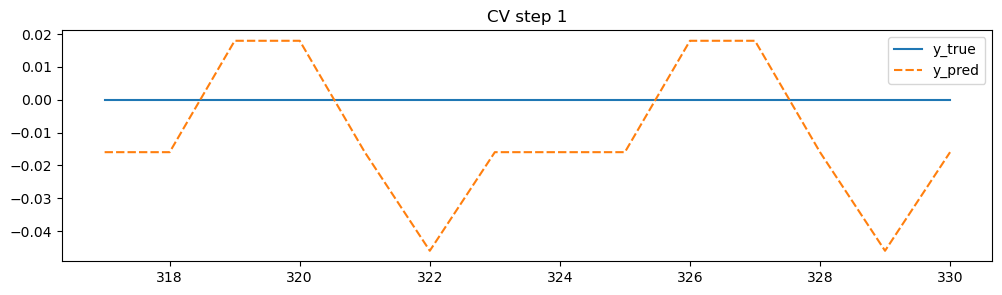

LGBM CV step 1 WAPE: 0.45227145855386625


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 10.2704
[200]	valid_0's l2: 10.3455
[300]	valid_0's l2: 10.6659


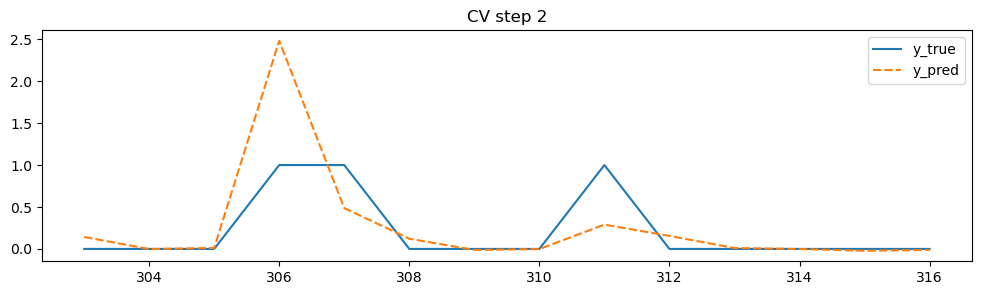

LGBM CV step 2 WAPE: 0.445979543692169


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 18.3097
[200]	valid_0's l2: 18.5185


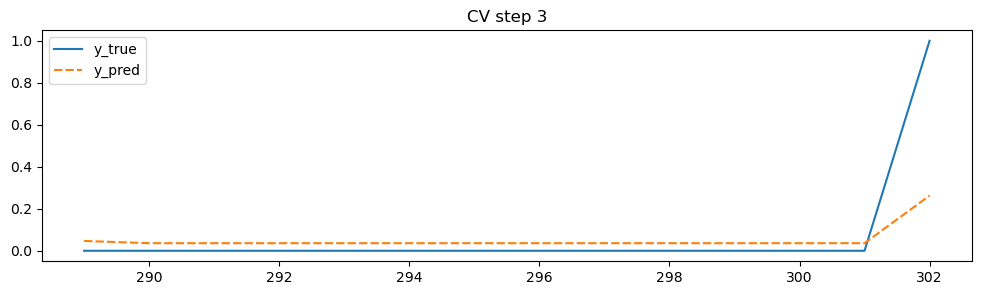

LGBM CV step 3 WAPE: 0.4625805948227136


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 15.4709
[200]	valid_0's l2: 15.828


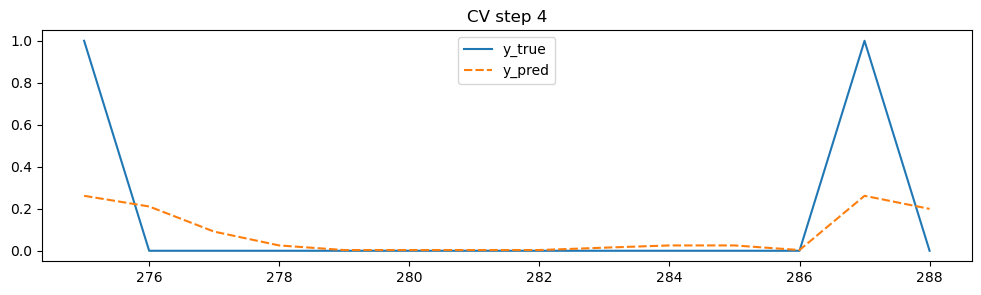

LGBM CV step 4 WAPE: 0.4692568298819025


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[100]	valid_0's l2: 26.4682
[200]	valid_0's l2: 27.0501


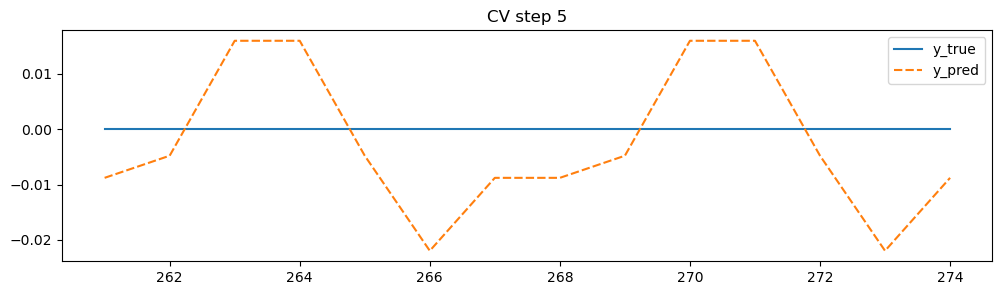

LGBM CV step 5 WAPE: 0.5090062886558933


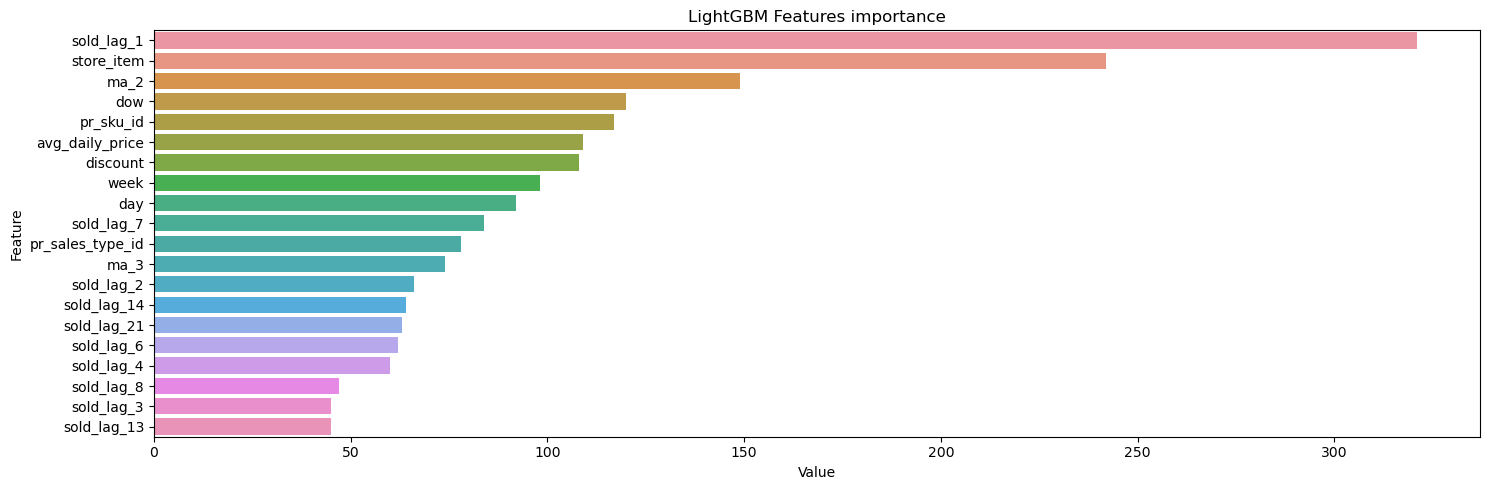

In [97]:
lgbm_wapes = lgbm_cross_val(df=with_ma, cat_features=['store_item', 
                                                          'pr_sales_type_id', 
                                                          'dow',  
                                                          'season', 'pr_sku_id', 'st_id'], 
                                            cols_to_drop=['date', 'sold'])

In [98]:
print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

LGBM mean WAPE = 0.4678189431213089


Итерация 1

* Фичи: товар-магазин, 21 лаг
* ВЭЙП: 0.31946023074607927
* Важное: Лаги 1, 6, 7, 21, 14, 13, товар-магазин

Итерация 2

* Фичи: товар-магазин, 21 лаг, флаг промо
* ВЭЙП: 0.31190542656037545
* Важное: Лаги 1, 7, товар-магазин, лаги 6, 21, промо, 14, 13
* Вывод: с флажком промо конечно лучше

Итерация 3

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5)
* ВЭЙП: 0.29543868373613635
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, неделя, промо, лаги 14, 6, 21, день месяца, лаги 13, 2, 4
* Вывод: месяц и сезон не важны. День недели, номер недели, день месяца - хорошие признаки

Итерация 4

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), айди товара и магазина
* ВЭЙП: 0.2983241429592106
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, промо, неделя, лаги 6, 14, 21, день месяца, лаги 13, 2, 4
* Вывод: эта фича не улучшила метрику и не вошла в топ. Я оставлю айдишники, чтобы по ним приджойнить типы и категории

Итерация 5

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), айди товара и магазина, вся инфа о магазине
* ВЭЙП: 0.29772025048047446
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, день месяца, промо, неделя, лаги 21, 14, 6, 13, 5, 15
* Вывод: вообще ничего полезного в инфо о магазине. Уберу их из датасета

Итерация 6

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), айди товара и магазина, вся инфа о товаре
* ВЭЙП: 0.2972128043054486
* Важное: Лаг 1, день недели, товар-магазин, промо, лаг 7, неделя, лаги 6, 14, 21, день месяца, лаги 2, 13, 15
* Вывод: категории и подкатегории не важны. можно вернуться на этап 3, когда добавили календарные фичи

Итерация 7

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена
* ВЭЙП: 0.29813939400486966
* Важное: Лаг 1, товар-магазин, лаг 2, средняя цена, лаги 7, 3, 6, неделя, лаг 15, день месяца, лаги 5, 4, 16, 14
* Вывод: средняя цена - важный признак. Почему тогда снизилась метрика??? модель потеряла недельную цикличность: день недели ушел из списка, лаги 7, 14, 21 снизились по важности, в топ вышли лаги последних дней. Еще и промо потерялось. Его можно убрать только на следующей итерации, когда добавим размер скидки

Итерация 8

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена. Минус лаги 2 и 3
* ВЭЙП: 0.29239544645625787
* Важное: Лаг 1, товар-магазин, средняя цена, лаги 7, 4, неделя, лаг 6, день месяца, лаги 8, 21, 14, 15, день недели
* Вывод: я сейчас верну эти лаги, просто хотелось немного подсказать модели. Пока это лучшая метрика. День недели вернулся, правильная сезонность восстановлена

Итерация 9

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки
* ВЭЙП: 0.2903170138654366
* Важное: Лаг 1, товар-магазин, день недели, лаг 7, промо, средняя цена, неделя, лаги 14, 21, 6, 2, день месяца 
* Вывод: мне такое распределение больше всего нравится. день неджели поднялся в топ3, флажок промо вернулся. Но она не видит мой процент скидки

Итерация 10

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки
* ВЭЙП: 0.32029594697514907
* Важное: Лаг 1, товар-магазин, день недели, лаги 2, 7, неделя, средняя цена, день месяца, лаги 14, 21, 8, 6, 13  
* Вывод: увеличила набор до топ100. Нельзя масштабировать без потери качества. Вернусь к 50. Хотя это не значит, что так делать не надо: может если мы построим разные модели для топ50 и остальных, после объединения качество упадет сильнее

Итерация 11

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки, канун праздника
* ВЭЙП: 0.2903170138654366
* Важное: Лаг 1, товар-магазин, день недели, лаги 2, 7, неделя, средняя цена, день месяца, лаги 14, 21, 8, 6, 13  
* Вывод: нет влияния на метрику. по-моему праздники просто не попадают в нашу валидацию. сделала больше фолдов кросс-валидации (чтобы выборка дотянулась до майских). тогда без новой фичи метрика чуть лучше, чем с ней

Итерация 12

* Фичи: товар-магазин, 21 лаг, флаг промо, календарные (5), цена, размер скидки, скользящие средние по продажам
* ВЭЙП: 0.29396104069940276
* Важное: Лаг 1, товар-магазин, средняя цена, МА2, лаг 2, неделя, лаги 14, 7, день месяца, лаг 16, МА3, день недели, лаги 20, 6, скидка  
* Вывод: нет влияния на метрику. по-моему праздники просто не попадают в нашу валидацию. сделала больше фолдов кросс-валидации (чтобы выборка дотянулась до майских). тогда без новой фичи метрика чуть лучше, чем с ней



In [58]:
def objective(trial, data=with_ma, cols_to_drop=['sold', 'date', 'pr_sku_id', 'st_id'], cat_features=['store_item', 'pr_sales_type_id', 'dow', 'season']):
    
    end_train = data['date'].max() - pd.Timedelta(days=14)
    train = data[data['date'] <= end_train]
    valid = data[data['date'] > end_train]

    train_x = train.drop(cols_to_drop, axis=1)
    train_y = train['sold']
    test_x = valid.drop(cols_to_drop, axis=1)
    test_y = valid['sold']

    cat_idx = [train_x.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        train_x[col] = pd.Categorical(train_x[col])
        test_x[col] = pd.Categorical(test_x[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,categorical_feature=cat_idx,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)

    trial.set_user_attr(key="best_booster", value=model)
    
    return wape(test_y, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-07 19:02:42,448] A new study created in memory with name: no-name-4b93f2ec-e1ad-401e-a2e3-8b1d94c6d92c
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced b

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 1.03522


[I 2023-10-07 19:03:48,778] Trial 0 finished with value: 0.4339494667404769 and parameters: {'reg_alpha': 2.7662877760664077, 'reg_lambda': 0.005248435640259021, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 731, 'min_child_samples': 170, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.4339494667404769.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_lo

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.30000000000000004


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-07 19:04:53,409] Trial 1 finished with value: 0.4317355656986636 and parameters: {'reg_alpha': 0.32080383276955704, 'reg_lambda': 0.020034676048996253, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 470, 'min_child_samples': 106, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.4317355656986636.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 1.09325
[1000]	valid_0's l1: 1.04278
[1500]	valid_0's l1: 1.04008
[2000]	valid_0's l1: 1.03856
[2500]	valid_0's l1: 1.03781


[I 2023-10-07 19:08:10,638] Trial 2 finished with value: 0.435023607783873 and parameters: {'reg_alpha': 0.4422217132308, 'reg_lambda': 8.096856055076438, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 828, 'min_child_samples': 235, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.4317355656986636.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 1.01595


[I 2023-10-07 19:11:12,755] Trial 3 finished with value: 0.4257532850503243 and parameters: {'reg_alpha': 0.19070429412109657, 'reg_lambda': 0.018333836260869176, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 892, 'min_child_samples': 41, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.4257532850503243.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 1.03728


[I 2023-10-07 19:12:52,556] Trial 4 finished with value: 0.4341211740303562 and parameters: {'reg_alpha': 0.024532516270452536, 'reg_lambda': 0.0016041614927721115, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 135, 'min_child_samples': 276, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.4257532850503243.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugges

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 1.04367


[I 2023-10-07 19:17:28,301] Trial 5 finished with value: 0.4285997559814294 and parameters: {'reg_alpha': 0.4890220065784068, 'reg_lambda': 0.24691341550673762, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 937, 'min_child_samples': 29, 'feature_fraction': 0.4}. Best is trial 3 with value: 0.4257532850503243.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_lo

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-07 19:19:48,258] Trial 6 finished with value: 0.427981309815555 and parameters: {'reg_alpha': 0.046358835064586025, 'reg_lambda': 3.042221045277692, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 523, 'min_child_samples': 254, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.4257532850503243.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 1.03451
[1000]	valid_0's l1: 1.01999


[I 2023-10-07 19:24:57,477] Trial 7 finished with value: 0.4275924754465763 and parameters: {'reg_alpha': 0.0018857931288959416, 'reg_lambda': 0.008000211908301524, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 713, 'min_child_samples': 201, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.4257532850503243.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugges

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.30000000000000004


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-07 19:27:14,595] Trial 8 finished with value: 0.43154337351917904 and parameters: {'reg_alpha': 0.1547824654158831, 'reg_lambda': 0.027497768551490307, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 355, 'min_child_samples': 219, 'feature_fraction': 0.30000000000000004}. Best is trial 3 with value: 0.4257532850503243.
C:\Users\Lev\AppData\Local\Temp\ipykernel_5904\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-07 19:29:34,869] Trial 9 finished with value: 0.4287768798276422 and parameters: {'reg_alpha': 0.004284103428076114, 'reg_lambda': 0.007007447285626467, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 372, 'min_child_samples': 75, 'feature_fraction': 0.6000000000000001}. Best is trial 3 with value: 0.4257532850503243.


Number of finished trials: 10
Best trial: {'reg_alpha': 0.19070429412109657, 'reg_lambda': 0.018333836260869176, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 892, 'min_child_samples': 41, 'feature_fraction': 0.8}


In [65]:
# study.optimize(objective, n_trials=10, callbacks=[callback])
# best_model=study.user_attrs["best_booster"]

C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\optuna\distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\sklearn.py:726: UserWa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.00848


[I 2023-10-05 12:20:44,681] Trial 10 finished with value: 0.3726769919080547 and parameters: {'reg_alpha': 0.424451346790042, 'reg_lambda': 0.0011636330037994855, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 985, 'min_child_samples': 294, 'feature_fraction': 0.9}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugge

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-05 12:21:17,854] Trial 11 finished with value: 0.3693523477150084 and parameters: {'reg_alpha': 0.0012940143217606524, 'reg_lambda': 0.20491506566845116, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 695, 'min_child_samples': 189, 'feature_fraction': 0.4}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-05 12:21:55,218] Trial 12 finished with value: 0.3686639629810691 and parameters: {'reg_alpha': 9.263457671460808, 'reg_lambda': 0.15229833373595758, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 986, 'min_child_samples': 116, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 4.0304


[I 2023-10-05 12:23:42,023] Trial 13 finished with value: 0.3701946707303571 and parameters: {'reg_alpha': 0.0010697822016387205, 'reg_lambda': 0.03301891363299904, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 788, 'min_child_samples': 120, 'feature_fraction': 0.9}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.su

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.98166


[I 2023-10-05 12:24:22,618] Trial 14 finished with value: 0.370192942589469 and parameters: {'reg_alpha': 0.24111300100774655, 'reg_lambda': 0.1180125096280293, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 586, 'min_child_samples': 211, 'feature_fraction': 0.5}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.99196
[1000]	valid_0's l1: 3.95973


[I 2023-10-05 12:26:07,195] Trial 15 finished with value: 0.36818969540086033 and parameters: {'reg_alpha': 0.007107772079155695, 'reg_lambda': 0.003215250661473057, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 835, 'min_child_samples': 11, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.su

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.99991
[1000]	valid_0's l1: 3.97274


[I 2023-10-05 12:28:22,460] Trial 16 finished with value: 0.36924406317072705 and parameters: {'reg_alpha': 0.006999142145110348, 'reg_lambda': 0.001061876904617282, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 843, 'min_child_samples': 9, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sug

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.6000000000000001


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.97124


[I 2023-10-05 12:29:39,844] Trial 17 finished with value: 0.3687340072962885 and parameters: {'reg_alpha': 0.15667411407603893, 'reg_lambda': 0.005723323587369398, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 917, 'min_child_samples': 46, 'feature_fraction': 0.6000000000000001}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lamb

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-10-05 12:30:13,182] Trial 18 finished with value: 0.36937891286986757 and parameters: {'reg_alpha': 0.8246733732761322, 'reg_lambda': 0.002849393846895762, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 687, 'min_child_samples': 79, 'feature_fraction': 0.4}. Best is trial 3 with value: 0.36783434583461944.
C:\Users\Lev\AppData\Local\Temp\ipykernel_15532\304466756.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.7


c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\Lev\miniconda3\envs\ds\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	valid_0's l1: 3.99508
[1000]	valid_0's l1: 3.96953
[1500]	valid_0's l1: 3.96489
[2000]	valid_0's l1: 3.95916


[I 2023-10-05 12:32:06,917] Trial 19 finished with value: 0.36790960248663257 and parameters: {'reg_alpha': 0.08439343106166337, 'reg_lambda': 0.003097521326883601, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 508, 'min_child_samples': 2, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.36783434583461944.


LGBM WAPE: 0.4257532850503243


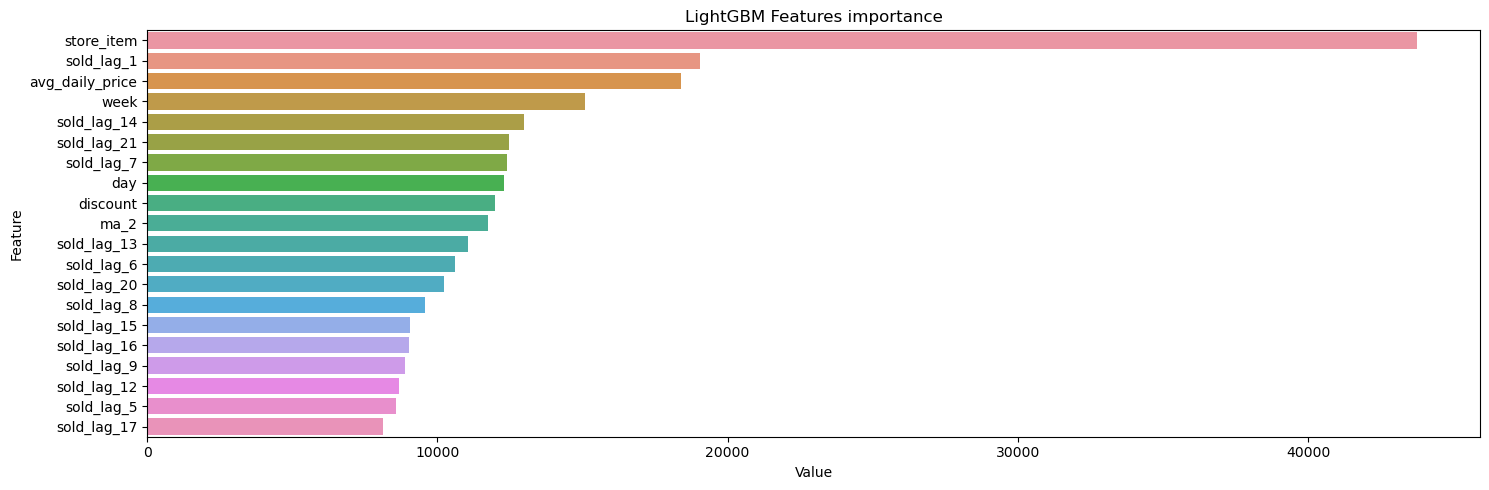

In [93]:
data=with_ma
cols_to_drop=['sold', 'date', 'pr_sku_id', 'st_id']
cat_features=['store_item', 'pr_sales_type_id', 'dow', 'season']

end_train = data['date'].max() - pd.Timedelta(days=14)
train = data[data['date'] <= end_train]
valid = data[data['date'] > end_train]

X_train = train.drop(cols_to_drop, axis=1)
y_train = train['sold']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['sold']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

LGBM WAPE: 0.28035633797758186
После оптимизации оптуной

Feature importance
1. store_item
2. lag 1
3. avg daily price
4. dow
5. ma2
6. lag 7
7. lag 21
8. day of month
9. week number 
10. lag 6
11. lag 14
12. discount %
13. lag 13
14. lag 20
15. lag 9
16. ma3
17. lag 2
18. lag 16
19. lag 11
20. lag 10

Для кросс-валидации мы выделили в качестве валидационной выборки последние 14 дней, оставив все предшествующие данные в обучающей выборке. Для второго фолда кросс-валидации мы сдвинули валидационную выборку на две недели раньше, тем самым на 14 дней сократив обучающую. Таким образом мы в цикле последовательно формируем 5 фолдов кросс-валидации, обучаем на хронологически первых данных градиентный бустинг, валидируем его на последних 14 днях и оцениваем важность признаков в порядке от наиболее к наименее важным. По изменениям метрики и графику важности признаков мы оцениваем признаки, добавленные в данной итерации. Наблюдения за процессом записаны в ячейке под обучением

Мы планируем в дальнейшем изменить алгоритм кросс-валидации, приведя его в соответствие с тем, как сейчас делаются предсказания на будущее. Сейчас при валидации в качестве лаговых переменных настоящие продажи. Мы не можем знать их цифр из прошлого, поэтому в качестве лага-1 для второго дня прогноза следует использовать прогноз для первого дня, а не реальные продажи, известные нам из датасета. Будем благодарны за рекомендацию, как реализовать это в коде

Для тюнинга гиперпараметров модели мы используем Оптуну. Мы полагаем, что это завершающий шаг, однако применили ее уже сейчас, поскольку по нашим наблюдениям после оптимизации порядок важности признаков наименее случаен, модель обучена максимально эффективно.

В целом по результатам моделирования видна ярко выраженная недельная сезонность. День недели - важный признак, как и лаги, кратные 7. Одну из первых позиций занимают также вчерашние продажи, это обеспечивает некоторую инерцию. Расчетная цена - важный признак. В дальнейшем мы планируем спрогнозировать ее моделью типа Аримы или Профета. Сейчас в прогнозе на этом признаке стоит заглушка, подразумевающая, что цена останется на уровне последнего дня. Вероятно одна и та же цена на протяжении 14 дней существенно снижает качество прогноза. Показатель процента скидки оказался не таким важным, как мы предполагали, не войдя в десятку. Номер недели относительно важен, значит, модель улавливает какой-то тренд. День месяца важен, что подтвержает нашу гипотезу о росте продаж в определенные дни, соответствующие традиционным дням зарплаты.

In [92]:
# save the model as a pickle file
model_pkl = "model.pkl"  

with open(model_pkl, 'wb') as file:  
    pickle.dump(lgbm_reg, file)

In [94]:
# load model from pickle file
with open(model_pkl, 'rb') as file:  
    lgbm_reg_loaded = pickle.load(file)

In [95]:
# evaluate model 
data=with_ma
cols_to_drop=['sold', 'date', 'pr_sku_id', 'st_id']
cat_features=['store_item', 'pr_sales_type_id', 'dow', 'season']

end_train = data['date'].max() - pd.Timedelta(days=14)
train = data[data['date'] <= end_train]
valid = data[data['date'] > end_train]

X_train = train.drop(cols_to_drop, axis=1)
y_train = train['sold']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['sold']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

preds = lgbm_reg_loaded.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

LGBM WAPE: 0.4257532850503243


In [96]:
with_ma.columns

Index(['store_item', 'date', 'sold', 'sold_lag_1', 'sold_lag_2', 'sold_lag_3',
       'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7', 'sold_lag_8',
       'sold_lag_9', 'sold_lag_10', 'sold_lag_11', 'sold_lag_12',
       'sold_lag_13', 'sold_lag_14', 'sold_lag_15', 'sold_lag_16',
       'sold_lag_17', 'sold_lag_18', 'sold_lag_19', 'sold_lag_20',
       'sold_lag_21', 'pr_sales_type_id', 'dow', 'day', 'week', 'month',
       'season', 'st_id', 'pr_sku_id', 'avg_daily_price', 'discount', 'ma_2',
       'ma_3', 'ma_4', 'ma_5', 'ma_6', 'ma_7', 'ma_8', 'ma_9', 'ma_10',
       'ma_11', 'ma_12', 'ma_13', 'ma_14', 'ma_15', 'ma_16', 'ma_17', 'ma_18',
       'ma_19', 'ma_20', 'ma_21'],
      dtype='object')

In [74]:
#saving train to a file
with_ma.to_csv('model1_sales.csv', index=False)

In [75]:
#load and check
sales_loaded = pd.read_csv('model1_sales.csv', parse_dates=['date'])
sales_loaded.dtypes

store_item                  object
date                datetime64[ns]
sold                       float64
sold_lag_1                 float64
sold_lag_2                 float64
sold_lag_3                 float64
sold_lag_4                 float64
sold_lag_5                 float64
sold_lag_6                 float64
sold_lag_7                 float64
sold_lag_8                 float64
sold_lag_9                 float64
sold_lag_10                float64
sold_lag_11                float64
sold_lag_12                float64
sold_lag_13                float64
sold_lag_14                float64
sold_lag_15                float64
sold_lag_16                float64
sold_lag_17                float64
sold_lag_18                float64
sold_lag_19                float64
sold_lag_20                float64
sold_lag_21                float64
pr_sales_type_id           float64
dow                          int64
day                          int64
week                         int64
month               

### Forecasting

In [65]:
#rewrite forecast algorythm so that the model could handle test with only store/sku/date
#get lines from submission form
sample_sub = pd.read_csv('sales_submission.csv')
sample_sub['date'] = pd.to_datetime(sample_sub['date']).dt.normalize()
pairs_set = sample_sub.groupby(['st_id', 'pr_sku_id']).min().reset_index()
pairs_set.shape

(3121, 4)

In [66]:
sample_sub.shape, 3121*14

((43694, 4), 43694)

In [67]:
def preprocess_test(pred_with_history, pred_price):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags
    pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sold_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'sold_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'sold']
        
    #no promo by default
    pred_with_history['pr_sales_type_id'] = 0
    pred_with_history['discount'] = 0    
    
    #add features of day-of-week, day-of-month, week, month, season
    pred_with_history['dow'] = pred_with_history['date'].dt.dayofweek
    pred_with_history['day'] = pred_with_history['date'].dt.day
    pred_with_history['week'] = pred_with_history['date'].dt.isocalendar().week.astype('int32')
    pred_with_history['month'] = pred_with_history['date'].dt.month
    pred_with_history['season'] = pred_with_history['date'].dt.quarter    
    
    #add Prophet-predicted price    
    pred_with_history['avg_daily_price'] = pred_price    
    
    #add moving averages
    for n in range(2, 22):
        pred_with_history['ma_' + str(n)] = pred_with_history[['sold_lag_' + str(x) for x in range(1, n+1)]].sum(axis=1) / n

    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [80]:
#this is what we'll get as input
first_pred = pairs_set.sample(1)
first_pred

,st_id,pr_sku_id,date,target
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-19,0


In [81]:
def make_forecast_for_sample_row(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    row['store_item'] = row['st_id'].str.cat(row['pr_sku_id'], sep='-')
    start_date = row['date']

    #predict price with Prophet
    avg_price_ts_df = with_ma[with_ma['store_item'] == row['store_item'].item()][['date', 'avg_daily_price']]
    avg_price_ts_df = avg_price_ts_df.sort_values(by='date')
    avg_price_ts_df = avg_price_ts_df.rename(columns={'date': 'ds', 'avg_daily_price': 'y'})
    prophet = Prophet()
    prophet.fit(avg_price_ts_df)
    future = prophet.make_future_dataframe(periods=h, freq='D')
    prices_forecast = prophet.predict(future)
    future_prices = prices_forecast[['ds', 'yhat']].tail(14).reset_index(drop=True)
        
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()        

        #if first line take lags from the last line of train. otherwise from previous predicted line
        if i == 0:
            last_train_date = with_ma['date'].max()
            upper_row = with_ma[(with_ma['store_item'] == lower_row['store_item'].item()) & (with_ma['date'] == last_train_date)]
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])
        last_preprocessed = preprocess_test(pred_with_history, future_prices.loc[i, 'yhat'].item())
        
        #drop columns before model
        X_test = last_preprocessed.drop(['sold', 'target', 'date', 'pr_sku_id', 'st_id'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row.drop('store_item', axis=1)])
        
    return forecast

make_forecast_for_sample_row(first_pred)

20:34:55 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing


,st_id,pr_sku_id,date,target
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-19,2
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-20,5
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-21,8
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-22,8
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-23,5
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-24,3
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-25,3
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-26,3
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-27,4
2385,f7e6c85504ce6e82442c770f7c8606f0,4d1c96d1e5434ae46286cc59c80fe542,2023-07-28,8


20:34:59 - cmdstanpy - INFO - Chain [1] start processing
20:34:59 - cmdstanpy - INFO - Chain [1] done processing


,sold,target
date,,
2023-07-05,2.0,NaN
2023-07-06,6.0,NaN
2023-07-07,14.0,NaN
2023-07-08,23.0,NaN
2023-07-09,9.0,NaN
2023-07-10,3.0,NaN
2023-07-11,3.0,NaN
2023-07-12,1.0,NaN
2023-07-13,14.0,NaN


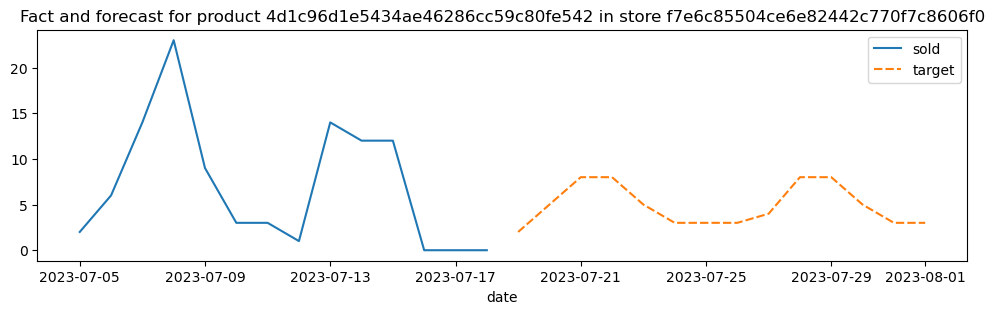

In [82]:
# same as previous function but plots fact-forecast
def forecast_and_plot(row, h=14):

    first_pred['store_item'] = first_pred['st_id'].str.cat(first_pred['pr_sku_id'], sep='-')
    last_train_date = with_ma['date'].max()
    
    fact = pd.DataFrame()    
    for i in range(14):
        line = with_ma[(with_ma['store_item'] == first_pred['store_item'].item()) & (with_ma['date'] == last_train_date - pd.Timedelta(days=(13-i)))]
        fact = pd.concat([fact, line[['st_id', 'pr_sku_id', 'date', 'sold']]])

    forecast = make_forecast_for_sample_row(first_pred)

    total = pd.concat([fact, forecast])[['date', 'sold', 'target']].set_index('date')
    display(total)

    fig, ax = plt.subplots(figsize=(12, 3))
    g = sns.lineplot(data=total)
    plt.title(f"Fact and forecast for product {first_pred['pr_sku_id'].item()} in store {first_pred['st_id'].item()}")
    plt.show()

    

forecast_and_plot(first_pred)


In [83]:
#it's time to fill the target column in submission file!
sample_sub['target'] = np.nan

sample_sub.isna().sum()

st_id            0
pr_sku_id        0
date             0
target       43694
dtype: int64

In [85]:
#not the best practice - iterating over a DF with a cycle, though let it be for now
common_forecast = pd.DataFrame()
for index, row in pairs_set.iterrows():
    try:
        forecast = make_forecast_for_sample_row(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))
        common_forecast = pd.concat([common_forecast, forecast])
    except:
        continue
    

20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:24 - cmdstanpy - INFO - Chain [1] start processing
20:39:24 - cmdstanpy - INFO - Chain [1] done processing
20:39:26 - cmdstanpy - INFO - Chain [1] start processing
20:39:26 - cmdstanpy - INFO - Chain [1] done processing
20:39:27 - cmdstanpy - INFO - Chain [1] start processing
20:39:27 - cmdstanpy - INFO - Chain [1] done processing
20:39:29 - cmdstanpy - INFO - Chain [1] start processing
20:39:29 - cmdstanpy - INFO - Chain [1] done processing
20:39:31 - cmdstanpy - INFO - Chain [1] start processing
20:39:31 - cmdstanpy - INFO - Chain [1] done processing
20:39:33 - cmdstanpy - INFO - Chain [1] start processing
20:39:33 - cmdstanpy - INFO - Chain [1] done processing
20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:34 - cmdstanpy - INFO - Chain [1] done processing
20:39:36 - cmdstanpy - INFO - Chain [1] start processing
20:39:36 - cmdstanpy - INFO - Chain [1]

In [86]:
#check that there are 14 days of forecast for each pair of 780
common_forecast.date.value_counts()

date
2023-07-19    2990
2023-07-20    2990
2023-07-21    2990
2023-07-22    2990
2023-07-23    2990
2023-07-24    2990
2023-07-25    2990
2023-07-26    2990
2023-07-27    2990
2023-07-28    2990
2023-07-29    2990
2023-07-30    2990
2023-07-31    2990
2023-08-01    2990
Name: count, dtype: int64

In [87]:
#update submission
updated_sub = sample_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
updated_sub.isna().sum()

st_id            0
pr_sku_id        0
date             0
target_x     43694
target_y      1834
dtype: int64

In [88]:
#return to original columns
updated_sub = updated_sub.rename(columns={'target_y': 'target'}).drop(['target_x'], axis=1)
updated_sub.isna().sum()

st_id           0
pr_sku_id       0
date            0
target       1834
dtype: int64

In [90]:
updated_sub = updated_sub.fillna(0)
updated_sub.isna().sum()

st_id        0
pr_sku_id    0
date         0
target       0
dtype: int64

In [91]:
#save to csv
updated_sub.to_csv('submission.csv', index=False)

В этой части реализована следующая логика:

1) мы выделяем в датасет flagman_sub пары товар-магазин, на которых обучали модель, оставляя более редкие товары с низкими продажами для предсказания следующей моделью

2) для каждой строки из тестовой выборки необходимо создать фичи по образу обучающей выборки. Для этого нам необходимо к каждой строке подтянуть данные по той же паре товар-магазин в предыдущий день. Если речь идет о первом дне прогноза, данные берем из последнего дня обучающей выборки. Для дней прогноза со 2 по 14 основанием для создания лагов и скользящих средних является предыдущая строка прогноза. Предобработка столбцов задана в функции preprocess_test. Функция make_forecast_for_sample_row принимает на вход строку из списка целевых пар и выдает датафрейм прогноза на 14 дней. Для наглядности ниже написана функция, которая тоже строит прогноз, но кроме того рисует график факта и прогноза

3) мы итерируемся по списку топовых пар товар-магазин и, выводя прогноз для каждой из них, конкатенируем их в единый датафрейм

4) соединяем датафрейм submission с полученным прогнозом, заполняя часть значений в столбце target. Для заполнения остальных переходим в следующий ноутбук